# Data

 The archive I found here contains over 30000 datasets which I condensed to a single file.
 
 Here you can find the complete data:
 https://www.ncei.noaa.gov/data/gsoy/archive/
 
 Documentation is found here: https://www1.ncdc.noaa.gov/pub/data/cdo/documentation/gsom-gsoy_documentation.pdf
 
 Website: https://www.ncdc.noaa.gov/cdo-web/datasets

I only provided the merged file here.

In [1]:
# import statements

import glob
import matplotlib.cm as cm
import matplotlib.colors as cls
import matplotlib.pyplot as plt
import mplleaflet
import numpy as np
import math
import pandas as pd
from sklearn.linear_model import LinearRegression

%matplotlib notebook

# Condense data

The following code filters out of over 85000 files the usable weather data and condenses to a single dataframe.

* Filter weather data which contains maximum, minimum and average temperatures.
* Calculate temperature changes by linear regression (s. comments below), data with less then 20 rows is filtered.

In [2]:
MIN_ROWS = 20

def calc_temp_coef(df, column_name):
    lin_reg = linear_regression(df, column_name)
    if lin_reg == None:
        return np.nan
    return lin_reg.coef_[0] * 100

def linear_regression(df, column_name, plot=False):
    df = df[df[column_name].notnull()] # remove empty rows
    if df.shape[0] < MIN_ROWS:
        return None
    X = np.array(df['DATE']).reshape(-1, 1) # year is on the x-axis
    y = df[column_name] # temperature is on the y-axis
    lin_reg = LinearRegression().fit(X, y)
    if (plot):
        plt.scatter(X, y, marker= 'o', s=50, alpha=0.8)
        plt.plot(X, lin_reg.coef_ * X + lin_reg.intercept_, 'r-')
    return lin_reg

def get_weather_data():
    '''
    Read data from all weather station. Data for each weather station is provided in single file.
    Calculate linear regression for TMAX and TMIN change: TEMP_COEF_MIN, TEMP_COEF_MAX
    :return: dict with condensed data
    '''
    weather_data = []
    list_of_files = glob.glob('./gsoy-latest/*.csv')
    # iterate over all data files
    for file_name in list_of_files:
        df = pd.read_csv(file_name)
        print('process {} size {}'.format(file_name, len(weather_data)))
        columns = df.columns
        # check existence of all relevant columns: TMAX, TMIN, LATITUDE, LONGITUDE
        if 'TMAX' in columns and 'TMIN' in columns and 'TAVG' in columns and 'LATITUDE' in columns and 'LONGITUDE' in columns:
            # remove rows with no provided TMAX + TMIN + AVG
            if df.shape[0] > 3:
                row = {}
                row['YEAR_MIN'] = df['DATE'].min() # first year with data
                row['YEAR_MAX'] = df['DATE'].max() # last year with data
                row['TEMP_COEF_MIN'] = calc_temp_coef(df, 'TMIN') # temperatur change in 100 years of min temp
                row['TEMP_COEF_MAX'] = calc_temp_coef(df, 'TMAX') #               "                of max temp
                row['TEMP_COEF_AVG'] = calc_temp_coef(df, 'TAVG') #               "                of avg temp
                row['LATITUDE'] = df['LATITUDE'].iloc[0]          # geo location of weather station
                row['LONGITUDE'] = df['LONGITUDE'].iloc[0]
                row['STATION'] = df['STATION'].iloc[0]            # id of weather station
                row['NAME'] = df['NAME'].iloc[0]                  # name of weather station
                weather_data.append(row)
    return weather_data


def persist_weather_data(weather_data):
    '''
    Persists weather data to csv file.
    '''
    df = pd.DataFrame(weather_data)
    df.to_csv("weather_data.csv")
    return df

# could not be activated in notebook here because 830 M data is transformed here.
# weather_data = persist_weather_data(get_weather_data())

In [3]:
def read_weather_data():
    '''
    Reads weather data persisted in persist_weather_data from csv file.
    '''
    return pd.read_csv("weather_data.csv")


def filter_by_year(weather_data, min_year, max_year):
    '''
    Filters weather data by min/max years in order to filter weather stations with a long range of data.
    '''
    return weather_data[(weather_data['YEAR_MIN'] < min_year) & (weather_data['YEAR_MAX'] > max_year)]


def filter_by_column(weather_data, min, max, column_name):
    '''
    Filters weather data by geo longitude.
    '''
    return weather_data[
        weather_data[column_name].notnull() & (weather_data[column_name] > min) & (weather_data[column_name] < max)
        ]


def color(value, minmax, colormap):
    '''
    How to use colormap: https://stackoverflow.com/questions/8931268/using-colormaps-to-set-color-of-line-in-matplotlib
    Predefined colormaps: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
    '''

    try:
        scalarMap = cm.ScalarMappable(cmap=colormap, norm=cls.Normalize(-minmax, minmax))
        return scalarMap.to_rgba(value, norm=True)
    except:
        print('exception: value {} min {} max {}'.format(value, min, max))



# Read data
Read condensed data and print out to map.

In [4]:
weather_data = read_weather_data()

# print statistics
# weather_data.reset_index().plot.scatter(x='index', y='YEAR_MAX')
# weather_data['YEAR_MAX'].plot.hist()
# weather_data['YEAR_MAX'].plot.hist()

# filter weather stations with a long data range
weather_data = filter_by_year(weather_data, 1900, 2000)

# filter weather stations by geo coordinates
# europe
weather_data_europe = filter_by_column(filter_by_column(weather_data, -12, 60, 'LONGITUDE'), 34, 70, 'LATITUDE')
# north america
weather_data_north_america = filter_by_column(filter_by_column(weather_data, -122, -72, 'LONGITUDE'), 26, 90, 'LATITUDE')
# south / east usa
# weather_data = filter_by_column(filter_by_column(weather_data, -95, -72, 'LONGITUDE'), 26, 37, 'LATITUDE')

# Print data

Print out data to map.

The following picture is rendered locally because the Jupyter Notebook shows problems with the complete dataset.

Further the color bar and legend could not be printed when using mplleaflet: https://stackoverflow.com/a/37103684/1909531
So it is printed out in an extra figure and merged manually.

Below you will find code which prints the data for North America.

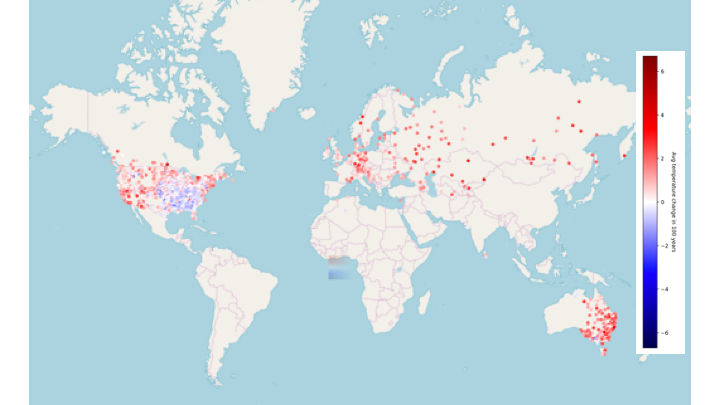

In [5]:
from IPython.display import Image
Image(filename='worldwide_bar.png') 

In [6]:
################
# Print Map
################

def annotations(weather_data):
    for i in range(0, weather_data.shape[0]):
        row = weather_data.iloc[i]
        plt.annotate(row['STATION'], xy=(row['LONGITUDE'], row['LATITUDE']), size=6)

def print_map(weather_data):
    weather_data = weather_data[weather_data['TEMP_COEF_AVG'].notnull()]
    temp_coefs = weather_data['TEMP_COEF_AVG']

    temp_coefs_max = temp_coefs.max()
    temp_coefs_min = temp_coefs.min()
    # we need a symmetric min/max to have zero values at the middle of the color map (=> white color)
    minmax = np.maximum(-temp_coefs_min, temp_coefs_max)

    # create color mapping
    colormap = plt.get_cmap('seismic')
    scalarMap = cm.ScalarMappable(cmap=colormap, norm=cls.Normalize(-minmax, minmax))
    scalarMap.to_rgba(0, norm=True)
    scalarMap.set_array([])

    colors = list(map(lambda column: color(column, minmax, colormap), temp_coefs))

    lons = weather_data['LONGITUDE'].tolist()
    lats = weather_data['LATITUDE'].tolist()

    sc = plt.scatter(lons, lats, c=colors, alpha=0.9, s=10)
    cbar = plt.colorbar(scalarMap, orientation="vertical")
    cbar.ax.set_ylabel('Avg temperature change in 100 years', rotation=270)
    cbar.ax.get_yaxis().labelpad = 15
    # annotations(weather_data)

    # https://stackoverflow.com/a/37103684/1909531
    # mplleaflet.save_html()
    # mplleaflet.display()

<IPython.core.display.Javascript object>


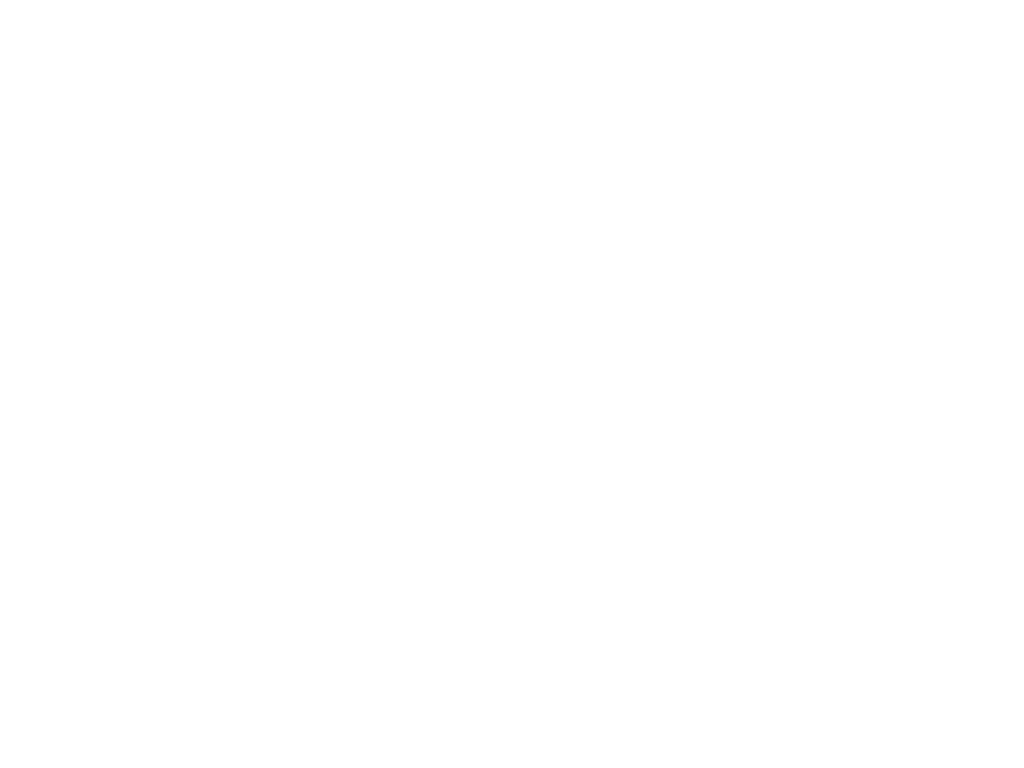

In [7]:
fig=plt.figure()
print_map(weather_data_europe)
mplleaflet.display()

# Print color bar
Unfortunately the color bar cannot be displayed on the map. Therefore it is printed in an extra figure here.

<IPython.core.display.Javascript object>


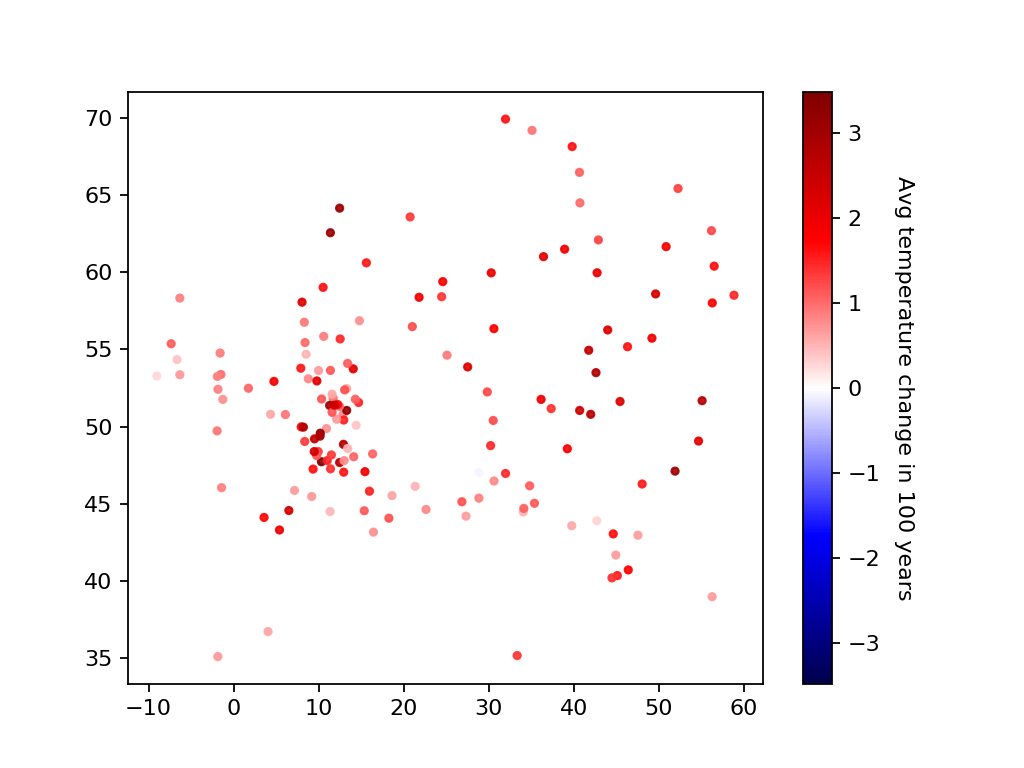

In [8]:
fig = plt.figure()
print_map(weather_data_europe)

# Histogram for Europe data

<IPython.core.display.Javascript object>


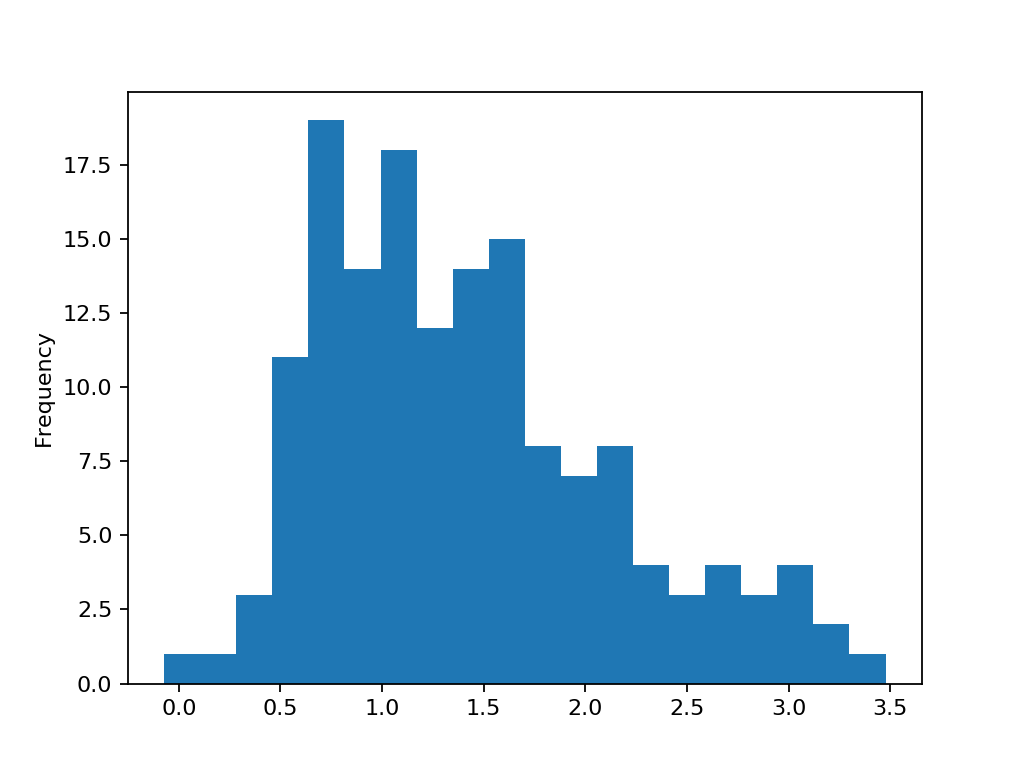

In [9]:
fig = plt.figure()
weather_data_europe['TEMP_COEF_AVG'].plot.hist(bins=20)